In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
import nltk
import Levenshtein

In [2]:
# make everything bold, comment out if you don't like it
plt.rcParams.update({'font.weight': 'bold', 'axes.labelweight': 'bold', 'axes.titleweight': 'bold'})


In [ ]:
nltk.download('wordnet')

In [4]:
ALPHA = 0.5

In [5]:
def calculate_levenshtein_accuracy(true_sentence, generated_sentence):
    distance = Levenshtein.distance(true_sentence, generated_sentence)
    max_len = max(len(true_sentence), len(generated_sentence))
    return 1 - (distance / max_len)

def calculate_bleu_score(true_sentence, generated_sentence):
    # Use a smoothing function to avoid BLEU score being zero
    smoothing_function = SmoothingFunction().method1
    return sentence_bleu(
        [true_sentence.split()], 
        generated_sentence.split(), 
        smoothing_function=smoothing_function
    )

def calculate_rouge_scores(true_sentence, generated_sentence):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(true_sentence, generated_sentence)
    rouge_scores = {
        "rouge1": scores['rouge1'].fmeasure,
        "rouge2": scores['rouge2'].fmeasure,
        "rougeL": scores['rougeL'].fmeasure
    }
    return list(rouge_scores.values())

def calculate_meteor_score(true_sentence, generated_sentence):
    # Tokenize sentences
    reference_tokens = true_sentence.split()
    generated_tokens = generated_sentence.split()
    # Calculate METEOR score
    return meteor_score([reference_tokens], generated_tokens)

def combined_score(levenshtein_accuracy, bleu_score, alpha=ALPHA):
    return alpha * levenshtein_accuracy + (1 - alpha) * bleu_score

In [6]:
# test rouge
true_sentence = "The quick brown fox jumps over the lazy dog"
generated_sentence = "The quick brown fox jumps over the lazy dog"
rouge_scores = calculate_rouge_scores(true_sentence, generated_sentence)
print(rouge_scores)

[1.0, 1.0, 1.0]


In [7]:
model_map = {
    'base': 'B-CoAtNet',
    'llama3_2_1b': 'LLAMA-3.2-1B',
    'llama3_2_3b': 'LLAMA-3.2-3B',
    'llama3_1_8b': 'LLAMA-3.1-8B',
    'gpt-4o': 'GPT-4o',
    'echocrypt': 'LLAMA-3.2-3B (Fine-tuned)',
}

In [8]:
main_dir = '.'

In [9]:
# Data holder for plotting
results = []
file_counter = 0

for model_dir in os.listdir(main_dir):
    model_path = os.path.join(main_dir, model_dir)
    if os.path.isdir(model_path):
        for csv_file in os.listdir(model_path):
            if csv_file.endswith('.csv'):
                csv_path = os.path.join(model_path, csv_file)
                df = pd.read_csv(csv_path)
                nf = float(csv_file.replace('.csv', '').replace('noise_', ''))

                print(f"nf changed to {nf}")

                model_name = model_dir
                # Calculate average accuracy for each CSV (noise factor)
                lev_accuracies = []
                bleu_accuracies = []
                for _, row in df.iterrows():
                    true_sentence = row['True Sentence']
                    predicted_sentence = row['Predicted Sentence']
                    llm_sentence = row['LLM Sentence']
                    
                    base_leven = calculate_levenshtein_accuracy(true_sentence, predicted_sentence)
                    base_bleu = calculate_bleu_score(true_sentence, predicted_sentence)
                    base_combined = combined_score(base_leven, base_bleu)
                    base_meteor = calculate_meteor_score(true_sentence, predicted_sentence)
                    base_rouge1, base_rouge2, base_rougeL = calculate_rouge_scores(true_sentence, predicted_sentence)
                    
                    llm_leven = calculate_levenshtein_accuracy(true_sentence, llm_sentence)
                    llm_bleu = calculate_bleu_score(true_sentence, llm_sentence)
                    llm_combined = combined_score(llm_leven, llm_bleu)
                    llm_meteor = calculate_meteor_score(true_sentence, llm_sentence)
                    llm_rouge1, llm_rouge2, llm_rougeL = calculate_rouge_scores(true_sentence, llm_sentence)
                    
                    if file_counter < 3:
                        results.append({
                            'Model': model_map['base'], # CoAtNet
                            'Noise Factor': nf,
                            'Levenshtein Accuracy': base_leven,
                            'BLEU Accuracy': base_bleu,
                            'Meteor Score': base_meteor,
                            'Rouge-1': base_rouge1,
                            'Rouge-2': base_rouge2,
                            'Rouge-L': base_rougeL,
                            'Adjusted Accuracy': base_combined,
                        })
                    
                    results.append({
                        'Model': model_map[model_name], # LLM
                        'Noise Factor': nf,
                        'Levenshtein Accuracy': llm_leven,
                        'BLEU Accuracy': llm_bleu,
                        'Meteor Score': llm_meteor,
                        'Rouge-1': llm_rouge1,
                        'Rouge-2': llm_rouge2,
                        'Rouge-L': llm_rougeL,
                        'Adjusted Accuracy': llm_combined,
                    })
        file_counter += 3


nf changed to 0.5
nf changed to 1.0
nf changed to 0.1
nf changed to 0.5
nf changed to 1.0
nf changed to 0.1
nf changed to 0.5
nf changed to 1.0
nf changed to 0.1
nf changed to 0.5
nf changed to 1.0
nf changed to 0.1
nf changed to 0.5
nf changed to 1.0
nf changed to 0.1


In [10]:
results

[{'Model': 'B-CoAtNet',
  'Noise Factor': 0.5,
  'Levenshtein Accuracy': 0.8269230769230769,
  'BLEU Accuracy': 0.016295846120958617,
  'Meteor Score': 0.0949367088607595,
  'Rouge-1': 0.19999999999999998,
  'Rouge-2': 0.0,
  'Rouge-L': 0.19999999999999998,
  'Adjusted Accuracy': 0.4216094615220177},
 {'Model': 'LLAMA-3.2-1B',
  'Noise Factor': 0.5,
  'Levenshtein Accuracy': 0.9615384615384616,
  'BLEU Accuracy': 0.8657099140685622,
  'Meteor Score': 0.8803427031189833,
  'Rouge-1': 0.9032258064516129,
  'Rouge-2': 0.896551724137931,
  'Rouge-L': 0.9032258064516129,
  'Adjusted Accuracy': 0.9136241878035118},
 {'Model': 'B-CoAtNet',
  'Noise Factor': 0.5,
  'Levenshtein Accuracy': 0.7096774193548387,
  'BLEU Accuracy': 0.01893405895135384,
  'Meteor Score': 0.10791366906474818,
  'Rouge-1': 0.22222222222222224,
  'Rouge-2': 0.0,
  'Rouge-L': 0.22222222222222224,
  'Adjusted Accuracy': 0.3643057391530963},
 {'Model': 'LLAMA-3.2-1B',
  'Noise Factor': 0.5,
  'Levenshtein Accuracy': 0.021

In [11]:
results_df = pd.DataFrame(results)
# re-order models based on model_map.values()
results_df['Model'] = pd.Categorical(results_df['Model'], model_map.values())
# results_df['Noise Factor'] = results_df['Noise Factor'].astype(str)
results_df

,Model,Noise Factor,Levenshtein Accuracy,BLEU Accuracy,Meteor Score,Rouge-1,Rouge-2,Rouge-L,Adjusted Accuracy
0,B-CoAtNet,0.5,0.826923,0.016296,0.094937,0.200000,0.000000,0.200000,0.421609
1,LLAMA-3.2-1B,0.5,0.961538,0.865710,0.880343,0.903226,0.896552,0.903226,0.913624
2,B-CoAtNet,0.5,0.709677,0.018934,0.107914,0.222222,0.000000,0.222222,0.364306
3,LLAMA-3.2-1B,0.5,0.021505,0.000000,0.000000,0.000000,0.000000,0.000000,0.010753
4,B-CoAtNet,0.5,0.841270,0.053077,0.315625,0.400000,0.111111,0.400000,0.447173
...,...,...,...,...,...,...,...,...,...
17995,LLAMA-3.2-3B,0.1,0.833333,0.454802,0.701449,0.769231,0.545455,0.769231,0.644068
17996,LLAMA-3.2-3B,0.1,0.972603,0.701688,0.905455,0.909091,0.800000,0.909091,0.837145
17997,LLAMA-3.2-3B,0.1,1.000000,1.000000,0.999500,1.000000,1.000000,1.000000,1.000000
17998,LLAMA-3.2-3B,0.1,1.000000,1.000000,0.999500,1.000000,1.000000,1.000000,1.000000


In [12]:

mean_df = results_df.groupby(['Model', 'Noise Factor']).mean().reset_index()
std_df = results_df.groupby(['Model', 'Noise Factor']).std().reset_index()

/tmp/ipykernel_1532666/2869310711.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = results_df.groupby(['Model', 'Noise Factor']).mean().reset_index()
/tmp/ipykernel_1532666/2869310711.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_df = results_df.groupby(['Model', 'Noise Factor']).std().reset_index()


In [13]:
mean_df.to_excel('mean.xlsx', index=False)
std_df.to_excel('std.xlsx', index=False)

In [14]:
df = mean_df.copy()
df2 = std_df.copy()

# Map Noise Factor to corresponding levels
noise_levels = {0.1: "Low", 0.5: "Mid", 1.0: "High"}
bold_model = "GPT-4o"
df["Noise Level"] = df["Noise Factor"].map(noise_levels)
df2["Noise Level"] = df2["Noise Factor"].map(noise_levels)

# Generate LaTeX table rows
def generate_latex_rows(df, std_df, metric_columns):
    latex_rows = []
    for metric in metric_columns:
        for noise_level in ["Low", "Mid", "High"]:
            subset = df[(df["Noise Level"] == noise_level)]
            subset_std = std_df[(std_df["Noise Level"] == noise_level)]
           
            row = f"        {metric} ({noise_level}) & " + " & ".join(
                f"{mean:.3f} $\\pm$ {std:.3f}" for mean, std in zip(subset[metric], subset_std[metric])
            ) + " \\\\"
            latex_rows.append(row)
        latex_rows.append("\midrule")
    return "\n".join(latex_rows)

# Specify metric columns
metric_columns = ["BLEU Accuracy", "Meteor Score", "Rouge-1", "Rouge-2", "Rouge-L"]

# Generate LaTeX rows for the specified metrics
latex_rows = generate_latex_rows(df, df2, metric_columns)

# Print the rows
print(latex_rows)


        BLEU Accuracy (Low) & 0.285 $\pm$ 0.218 & 0.657 $\pm$ 0.297 & 0.827 $\pm$ 0.211 & 0.891 $\pm$ 0.167 & 0.976 $\pm$ 0.070 & 0.955 $\pm$ 0.099 \\
        BLEU Accuracy (Mid) & 0.050 $\pm$ 0.057 & 0.193 $\pm$ 0.225 & 0.385 $\pm$ 0.273 & 0.520 $\pm$ 0.288 & 0.896 $\pm$ 0.152 & 0.866 $\pm$ 0.184 \\
        BLEU Accuracy (High) & 0.018 $\pm$ 0.022 & 0.025 $\pm$ 0.055 & 0.081 $\pm$ 0.126 & 0.107 $\pm$ 0.151 & 0.542 $\pm$ 0.303 & 0.489 $\pm$ 0.303 \\
\midrule
        Meteor Score (Low) & 0.551 $\pm$ 0.191 & 0.811 $\pm$ 0.211 & 0.923 $\pm$ 0.101 & 0.952 $\pm$ 0.076 & 0.988 $\pm$ 0.031 & 0.979 $\pm$ 0.043 \\
        Meteor Score (Mid) & 0.210 $\pm$ 0.143 & 0.412 $\pm$ 0.261 & 0.646 $\pm$ 0.216 & 0.751 $\pm$ 0.186 & 0.950 $\pm$ 0.073 & 0.938 $\pm$ 0.088 \\
        Meteor Score (High) & 0.065 $\pm$ 0.076 & 0.085 $\pm$ 0.117 & 0.268 $\pm$ 0.191 & 0.319 $\pm$ 0.200 & 0.735 $\pm$ 0.218 & 0.710 $\pm$ 0.226 \\
\midrule
        Rouge-1 (Low) & 0.608 $\pm$ 0.161 & 0.826 $\pm$ 0.190 & 0.927 $\pm$ 0

In [15]:
noise_values = list(noise_levels.keys())
noise_labels = list(noise_levels.values())
print(noise_values)
print(noise_labels)

[0.1, 0.5, 1.0]
['Low', 'Mid', 'High']


['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'LLAMA-3.2-3B (Fine-tuned)']
Categories (6, object): ['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'LLAMA-3.2-3B (Fine-tuned)']


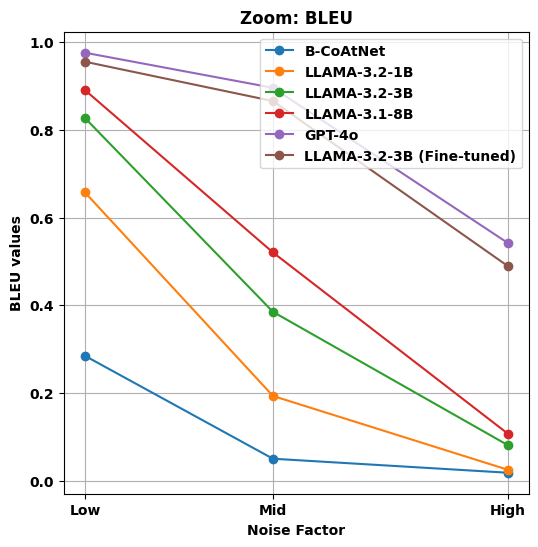

In [16]:
import math 

models = mean_df["Model"].unique()
print(models)
plt.figure(figsize=(6, 6))

for model in models:
    mean_subset = mean_df[mean_df["Model"] == model]
    std_subset = std_df[std_df["Model"] == model]
    
    # Extracting values and ensuring alignment
    x_values = mean_subset["Noise Factor"].values
    y_mean = mean_subset["BLEU Accuracy"].values
    # y_std = std_subset["BLEU Accuracy"].values 
    y_std = 0
    
    # Calculating bounds
    lower_bound = y_mean - y_std
    upper_bound = y_mean + y_std
    
    # Plotting mean line
    plt.plot(x_values, y_mean, marker='o', label=model)
    
    # Adding shaded area
    plt.fill_between(x_values, lower_bound, upper_bound, alpha=0.2)

plt.title("Zoom: BLEU")
plt.xlabel("Noise Factor")
plt.xticks(noise_values, labels=noise_labels)
plt.ylabel("BLEU values")
plt.legend()
plt.grid(True)
plt.savefig("bleu_zoom.pdf")
plt.show()

['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'LLAMA-3.2-3B (Fine-tuned)']
Categories (6, object): ['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'LLAMA-3.2-3B (Fine-tuned)']


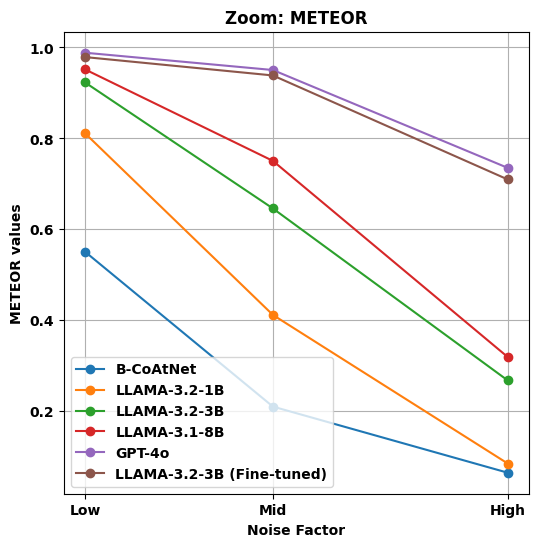

In [17]:
import math 

models = mean_df["Model"].unique()
print(models)
plt.figure(figsize=(6, 6))

for model in models:
    mean_subset = mean_df[mean_df["Model"] == model]
    std_subset = std_df[std_df["Model"] == model]
    
    # Extracting values and ensuring alignment
    x_values = mean_subset["Noise Factor"].values
    y_mean = mean_subset["Meteor Score"].values
    # y_std = std_subset["BLEU Accuracy"].values 
    y_std = 0
    
    # Calculating bounds
    lower_bound = y_mean - y_std
    upper_bound = y_mean + y_std
    
    # Plotting mean line
    plt.plot(x_values, y_mean, marker='o', label=model)
    
    # Adding shaded area
    plt.fill_between(x_values, lower_bound, upper_bound, alpha=0.2)

plt.title("Zoom: METEOR")
plt.xlabel("Noise Factor")
plt.xticks(noise_values, labels=noise_labels)
plt.ylabel("METEOR values")
plt.legend()
plt.grid(True)
plt.savefig("meteor_zoom.pdf")
plt.show()

['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'LLAMA-3.2-3B (Fine-tuned)']
Categories (6, object): ['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'LLAMA-3.2-3B (Fine-tuned)']


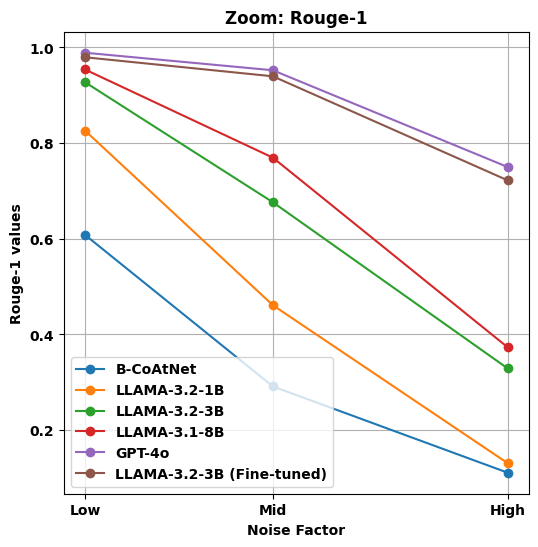

In [18]:
import math 

models = mean_df["Model"].unique()
print(models)
plt.figure(figsize=(6, 6))

for model in models:
    mean_subset = mean_df[mean_df["Model"] == model]
    std_subset = std_df[std_df["Model"] == model]
    
    # Extracting values and ensuring alignment
    x_values = mean_subset["Noise Factor"].values
    y_mean = mean_subset["Rouge-1"].values
    # y_std = std_subset["BLEU Accuracy"].values 
    y_std = 0
    
    # Calculating bounds
    lower_bound = y_mean - y_std
    upper_bound = y_mean + y_std
    
    # Plotting mean line
    plt.plot(x_values, y_mean, marker='o', label=model)
    
    # Adding shaded area
    plt.fill_between(x_values, lower_bound, upper_bound, alpha=0.2)

plt.title("Zoom: Rouge-1")
plt.xlabel("Noise Factor")
plt.xticks(noise_values, labels=noise_labels)
plt.ylabel("Rouge-1 values")
plt.legend()
plt.grid(True)
plt.savefig("rouge1_zoom.pdf")
plt.show()

['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'LLAMA-3.2-3B (Fine-tuned)']
Categories (6, object): ['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'LLAMA-3.2-3B (Fine-tuned)']


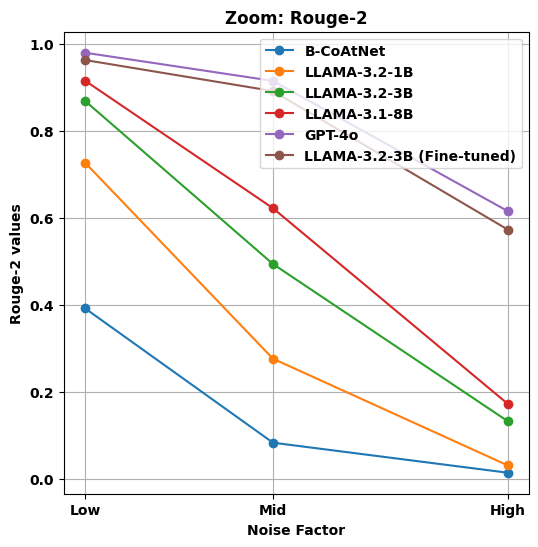

In [19]:
import math 

models = mean_df["Model"].unique()
print(models)
plt.figure(figsize=(6, 6))

for model in models:
    mean_subset = mean_df[mean_df["Model"] == model]
    std_subset = std_df[std_df["Model"] == model]
    
    # Extracting values and ensuring alignment
    x_values = mean_subset["Noise Factor"].values
    y_mean = mean_subset["Rouge-2"].values
    # y_std = std_subset["BLEU Accuracy"].values 
    y_std = 0
    
    # Calculating bounds
    lower_bound = y_mean - y_std
    upper_bound = y_mean + y_std
    
    # Plotting mean line
    plt.plot(x_values, y_mean, marker='o', label=model)
    
    # Adding shaded area
    plt.fill_between(x_values, lower_bound, upper_bound, alpha=0.2)

plt.title("Zoom: Rouge-2")
plt.xlabel("Noise Factor")
plt.xticks(noise_values, labels=noise_labels)
plt.ylabel("Rouge-2 values")
plt.legend()
plt.grid(True)
plt.savefig("rouge2_zoom.pdf")
plt.show()

['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'LLAMA-3.2-3B (Fine-tuned)']
Categories (6, object): ['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'LLAMA-3.2-3B (Fine-tuned)']


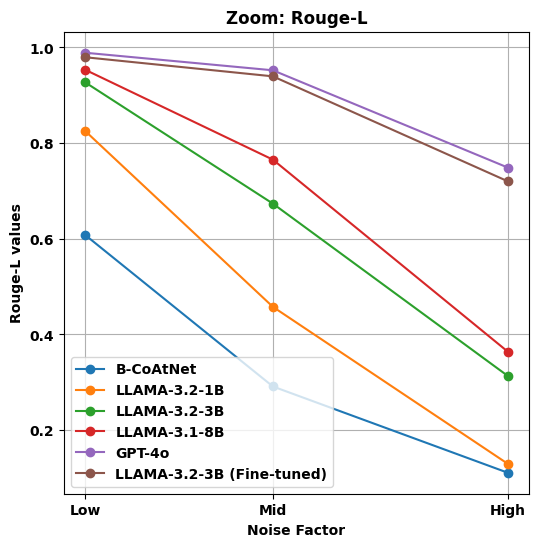

In [20]:
import math 

models = mean_df["Model"].unique()
print(models)
plt.figure(figsize=(6, 6))

for model in models:
    mean_subset = mean_df[mean_df["Model"] == model]
    std_subset = std_df[std_df["Model"] == model]
    
    # Extracting values and ensuring alignment
    x_values = mean_subset["Noise Factor"].values
    y_mean = mean_subset["Rouge-L"].values
    # y_std = std_subset["BLEU Accuracy"].values 
    y_std = 0
    
    # Calculating bounds
    lower_bound = y_mean - y_std
    upper_bound = y_mean + y_std
    
    # Plotting mean line
    plt.plot(x_values, y_mean, marker='o', label=model)
    
    # Adding shaded area
    plt.fill_between(x_values, lower_bound, upper_bound, alpha=0.2)

plt.title("Zoom: Rouge-L")
plt.xlabel("Noise Factor")
plt.xticks(noise_values, labels=noise_labels)
plt.ylabel("Rouge-L values")
plt.legend()
plt.grid(True)
plt.savefig("rougeL_zoom.pdf")
plt.show()